## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units=n_units,
                                   activation = 'relu',
                                   name = 'hidden_layer' + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation = 'relu',
                                   name = 'hidden_layer' + str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [13]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop = []
steps = [5, 10, 25]

for i, time in enumerate(steps):
    es = EarlyStopping(monitor="val_accuracy", patience=time, verbose=1)
    earlystop.append(es)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i,early_stop in enumerate(earlystop):
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data = (x_test,y_test),
              shuffle=True,
              callbacks=[early_stop])
    
    #Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = (f'earlystop with : {steps[i]}')
    results[exp_name_tag] = {"train_loss": train_loss,
                             "valid_loss": valid_loss,
                             "train_acc": train_acc,
                             "valid_acc": valid_acc}


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

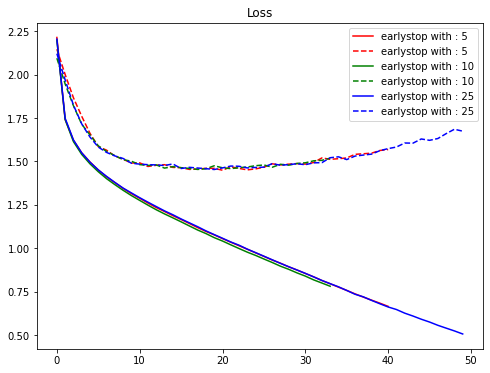

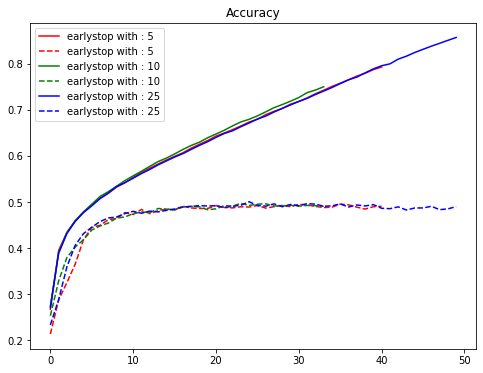

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b"]

plt.figure(figsize = (8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_loss"])), results[cond]["train_loss"],
             "-", label = cond, c = color_bar[i])
    plt.plot(range(len(results[cond]["valid_loss"])), results[cond]["valid_loss"],
             "--", label = cond, c = color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_acc"])), results[cond]["train_acc"],
             "-", label = cond, c = color_bar[i])
    plt.plot(range(len(results[cond]["valid_acc"])), results[cond]["valid_acc"],
             "--", label = cond, c = color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()